In [1]:
%load_ext autoreload
%autoreload 2

# Tutorial on q-Holder Bound

The q-Holder bound is the newest tight bound on Type I Error.
This notebook aims to provide the simplest example on using the q-Holder bound in `confirm`.
The q-Holder bound comes in two variations: forward and backward.
The forward mode is used as part of the "validation" step where it computes the q-Holder bound directly
given the Type I Error at the simulation point.
The backward mode is used as part of the "tuning" step where it computes the inverted forward q-Holder bound
given the desired Type I Error in the tile.

For this tutorial, we will focus on Binomial family since it is one of the most useful applications
and requires non-trivial implementation to compute these bounds.

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy
from functools import partial
import matplotlib.pyplot as plt
import pyimprint.grid as pygrid
import confirm.mini_imprint.grid as grid
from confirm.mini_imprint.bound import binomial as binomial

## Validation Step

Consider $n$ (size parameter of Binomial family), 
$\theta_0$ (logit parameter of Binomial family) simulation point, $v \in H-\theta_0$ any displacement vector, 
where $H$ is the tile associated with $\theta_0$.
As an example, suppose that the test has a Type I Error of $f(\theta_0)$.

In [3]:
n = 350                                 # size
theta_0 = np.array([-1., 0., 0.5])      # sim point
v = 0.1 * np.ones(theta_0.shape[0])     # displacement
f0 = 0.01                               # Type I Error at theta_0

We can compute the forward q-Holder bound by calling `q_holder_bound_fwd` with the above information and the hyperparameter $q$.

In [4]:
binomial.q_holder_bound_fwd(
    q=2.5, n=n, theta_0=theta_0, v=v, f0=f0,
)

DeviceArray(0.37938976, dtype=float32)

However, note that the bound is incredibly sensitive to the $q$-value.
In the above, we manually found a $q$ that provides decent performance,
but if we changed $q$ to a different value, the bound could potentially explode.

In [5]:
binomial.q_holder_bound_fwd(
    q=10, n=n, theta_0=theta_0, v=v, f0=f0,
)

DeviceArray(613.1688, dtype=float32)

For this reason, we provide a JAX-based class `ForwardQCPSolver` that optimizes for $q$
based on the other inputs.

In [6]:
fwd_solver = binomial.ForwardQCPSolver(n=n)
q_opt = fwd_solver.solve(theta_0=theta_0, v=v, a=f0) # optimal q
q_opt

DeviceArray(1.9665824, dtype=float32, weak_type=True)

As a sanity check, we can plot the bound as a function of $q$ and check that the optimal $q$
indeed achieves the minimum value.

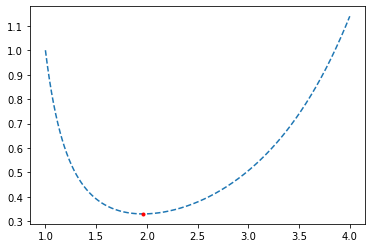

In [7]:
def _sanity_check_fwd_solver():
    q_grid = np.linspace(1+1e-6, 4, 1000)
    bound_vmap = jax.vmap(binomial.q_holder_bound_fwd, in_axes=(0, None, None, None, None))
    bounds = bound_vmap(q_grid, n, theta_0, v, f0)
    opt_bound = binomial.q_holder_bound_fwd(q_opt, n, theta_0, v, f0)
    plt.plot(q_grid, bounds, '--')
    plt.plot(q_opt, opt_bound, 'r.')
_sanity_check_fwd_solver()

So far, we are able to tightly bound $f(\theta_0 + v)$ for a fixed $v$ based on $\theta_0, f(\theta_0)$ and an optimal choice of $q$.
However, we would like to find a tight bound on for all $v \in H-\theta_0$.
Luckily, we can prove that the q-Holder bound takes its maximum on one of the corners of $H-\theta_0$ so long as the objective
is separable and the tile is rectangular (if not, we can embed the tile in a rectangle and find a further upper bound by maximizing on the rectangle).

The following shows an example for computing the maximum on a tile.

In [8]:
# Create corners of the tile with a given max radius.
radius = 0.1
v_coords = [[-1., 1.]] * theta_0.shape[0]
mgrid = np.meshgrid(*v_coords, indexing='ij')
vs = radius * np.concatenate([coord.reshape(-1,1) for coord in mgrid], axis=1)
vs

array([[-0.1, -0.1, -0.1],
       [-0.1, -0.1,  0.1],
       [-0.1,  0.1, -0.1],
       [-0.1,  0.1,  0.1],
       [ 0.1, -0.1, -0.1],
       [ 0.1, -0.1,  0.1],
       [ 0.1,  0.1, -0.1],
       [ 0.1,  0.1,  0.1]])

In [9]:
def q_holder_bound_fwd_tile(n, theta_0, vs, f0, fwd_solver):
    # vectorize fwd_solver over v
    fwd_solver_vmap_v = jax.vmap(
        fwd_solver.solve,
        in_axes=(None, 0, None),
    )
    q_opts = fwd_solver_vmap_v(theta_0, vs, f0)
    
    # compute bounds over q_opt, v
    bound_vmap = jax.vmap(
        binomial.q_holder_bound_fwd,
        in_axes=(0, None, None, 0, None),
    )
    bounds = bound_vmap(
        q_opts, n, theta_0, vs, f0,
    )
    
    # find the maximin of the bounds at corners
    i_max = jnp.argmax(bounds)
    return vs[i_max], q_opts[i_max], bounds[i_max]

In [10]:
v_opt, q_opt, bound_opt = q_holder_bound_fwd_tile(
    n=n, theta_0=theta_0, vs=vs, f0=f0, fwd_solver=fwd_solver,
)
v_opt, q_opt, bound_opt

(array([ 0.1,  0.1, -0.1]),
 DeviceArray(1.9457506, dtype=float32),
 DeviceArray(0.3366718, dtype=float32))

### Main Workflow

The main workflow is to apply this technique in parallel on many tiles.
For each tile (and its corresponding simulation point),
we would like to optimize for $q$ based on the worse corner.

The following is an example of a workflow.
We start with an array of simulation points `thetas` and the radius that defines the boundaries of the rectangular tile `radii`.
For this example, we are using the helper function `make_cartesian_grid_range`, but any `thetas, radii` will do.
The vertices for each tile are explicitly computed using `radii`.
Assume that we have access to the Type I Error values at each of the `thetas`.

In [11]:
gr = pygrid.make_cartesian_grid_range(
    size=100, 
    lower=-np.ones(2), 
    upper=np.ones(2), 
    grid_sim_size=0, # dummy for now
)
thetas = gr.thetas().T
subset = thetas[:, 0] >= thetas[:, 1]
thetas = thetas[subset]
radii = gr.radii().T
radii = radii[subset]

# dummy function to output TIE of a simple test.
def simple_TIE(n, theta, alpha):
    prob = scipy.special.expit(theta)
    var = np.sum(n * prob * (1 - prob), axis=-1)
    mean = n * (prob[:, 1] - prob[:, 0]) / np.sqrt(var)
    z_crit = scipy.stats.norm.isf(alpha)
    return scipy.stats.norm.sf(z_crit - mean)

f0s = simple_TIE(n, thetas, 0.025) 

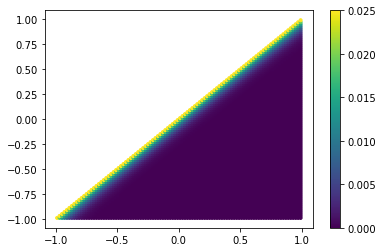

In [12]:
sc = plt.scatter(thetas[:, 0], thetas[:, 1], c=f0s, marker='.')
plt.colorbar(sc)

In [13]:
hypercube = grid.hypercube_vertices(
    thetas.shape[1],
)
make_vertices = jax.vmap(
    lambda r: r * hypercube,
    in_axes=(0,),
)
vertices = make_vertices(radii)

Finally, we vectorize the routine from before to get the best bound for the worse corner for each tile.

In [14]:
q_holder_bound_fwd_tile_jvmap = jax.jit(jax.vmap(
    lambda n, t, v, f0: q_holder_bound_fwd_tile(n, t, v, f0, fwd_solver)[-1],
    in_axes=(None, 0, 0, 0),
))

In [15]:
bounds = q_holder_bound_fwd_tile_jvmap(
    n, thetas, vertices, f0s,
)

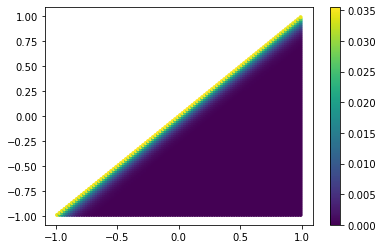

In [16]:
sc = plt.scatter(thetas[:,0], thetas[:,1], c=bounds, marker='.')
plt.colorbar(sc)

## Tuning Step 

In the tuning step, we invert the q-Holder bound and optimize a different objective.
The inversion gives us a bound on the TIE at `theta_0` in order to achieve level alpha in a tile.
Intuitively, we would like this inverted bound to be as large as possible (less conservative).
Hence, the `q` parameter allows us to maximize the bound for any given `v`.

In [24]:
bwd_solver = binomial.BackwardQCPSolver(n=n)

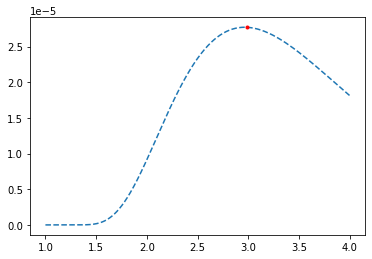

In [25]:
def _sanity_check_bwd_solver():
    q_grid = np.linspace(1+1e-6, 4, 1000)
    bound_vmap = jax.vmap(binomial.q_holder_bound_bwd, in_axes=(0, None, None, None, None))
    bounds = bound_vmap(q_grid, n, theta_0, v, f0)
    q_opt = bwd_solver.solve(theta_0, v, f0)
    opt_bound = binomial.q_holder_bound_bwd(q_opt, n, theta_0, v, f0)
    plt.plot(q_grid, bounds, '--')
    plt.plot(q_opt, opt_bound, 'r.')
_sanity_check_bwd_solver()

Similar to the validation step, we will extend the optimization routine for the whole tile.

In [26]:
def q_holder_bound_bwd_tile(n, theta_0, vs, f0, bwd_solver):
    # vectorize bwd_solver over v
    bwd_solver_vmap_v = jax.vmap(
        bwd_solver.solve,
        in_axes=(None, 0, None),
    )
    q_opts = bwd_solver_vmap_v(theta_0, vs, f0)
    
    # compute bounds over q_opt, v
    bound_vmap = jax.vmap(
        binomial.q_holder_bound_bwd,
        in_axes=(0, None, None, 0, None),
    )
    bounds = bound_vmap(
        q_opts, n, theta_0, vs, f0,
    )
    
    # find the minimax of the bounds at corners
    i_max = jnp.argmin(bounds)
    return vs[i_max], q_opts[i_max], bounds[i_max]

In [42]:
def invert_bound(alpha, theta_0, vertices, n):
    v = vertices - theta_0
    q_opt = jax.vmap(bwd_solver.solve, in_axes=(None, 0, None))(
        theta_0, v, alpha
    )
    return jnp.min(jax.vmap(binomial.q_holder_bound_bwd, in_axes=(0, None, None, 0, None))(
        q_opt, n, theta_0, v, alpha
    ))

In [44]:
q_holder_bound_bwd_tile(
    n, theta_0, vs, f0, bwd_solver
)

(array([ 0.1, -0.1, -0.1]),
 DeviceArray(2.949464, dtype=float32),
 DeviceArray(2.5628977e-05, dtype=float32))

### Main Workflow

The main workflow is similar to that of validation step.
For each tile (and its corresponding simulation point),
we would like to optimize for $q$ based on the worse corner
of the backward bound.

The following is an example of a workflow.
We continue with the setup as in validation step.

In [31]:
q_holder_bound_bwd_tile_jvmap = jax.jit(jax.vmap(
    lambda n, t, v, f0: q_holder_bound_bwd_tile(n, t, v, f0, bwd_solver)[-1],
    in_axes=(None, 0, 0, 0),
))

In [38]:
bounds_bwd = q_holder_bound_bwd_tile_jvmap(
    n, thetas, vertices, f0s,
)

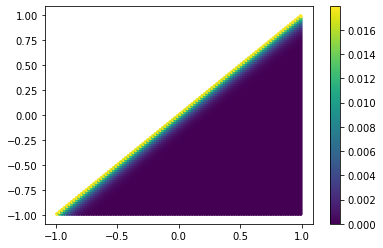

In [41]:
sc = plt.scatter(thetas[:,0], thetas[:,1], c=bounds_bwd, marker='.')
plt.colorbar(sc)